# Statistics

* There are 1,006,924 documents in the Megaspeech corpus.
* 50.3% non-hate (506,799) and 49.7% hate (500,125) examples

## Sentence Level
MegaSpeech tends to use more pronouns in hate speech that are used to divide people into an "us" vs "them" mindset. Divisive language.

### Word Count
* Hate Mean Word Count: 20.2282
* Non-Hate Mean Word Count: 18.2288
* The mode for word count is 20 for both
* These means are considered statistically significant under a two-sided two-sample t-test with results:
    * T-statistic: 186.044
    * P-value: 0.0
### Unique Words Count
* Hate Mean Unique Words: 18.3662
* Non-Hate Mean Unique Words: 16.7768
* The mode for unique word count is 18 for both
* These means are considered statistically significant under a two-sided two-sample t-test with results:
    * T-statistic: 170.482
    * P-value: 0.0

## Corpus Level
### Word Count
* There are 215,303 words in the hate corpus that are not in the non-hate corpus
    * This count decreases exponentially as the threshold for the word count increases
    * The words are an amalgam of 2 or 3 short words and resembles a hashtag

### Unique Word Count
* The hate speech corpus has 308,673 unique words
* The non-hate corpus has 477,706 unique words


### GPT-2 was finetuned on the following datasets
1. T. Davidson, D. Warmsley, M. Macy, and I. Weber,
“Automated hate speech detection and the problem of
offensive language,” in Proc. 11th Int. AAAI Conf. Web
Social Media, 2017, pp. 512–515.
    * Collected Tweets using a keyword search of HateBase words
2. Z. Waseem and D. Hovy, “Hateful symbols or hateful
people? predictive features for hate speech detection
on twitter,” in Proc. NAACL Student Res. Workshop,
2016, pp. 88–93.
   * search tweets for common slurs and terms used pertaining to religious, sexual, gender, and ethnic minorities.
   * All terms queried for: “MKR”, “asian drive”, “feminazi”, “immigrant”, “nigger”, “sjw”, “WomenAgainstFeminism”, “blameonenotall”, “islam", terrorism”, “notallmen”, “victimcard”, “victim card”, “arab terror”, “gamergate”, “jsil”, “racecard”, “race card”

3. V. Basile et al., “Semeval-2019 task 5: Multilingual
detection of hate speech against immigrants and
women in twitter,” in Proc. 13th Int. Workshop Semantic
Eval., 2019, pp. 54–63.
    * Keywords: https://github.com/msang/hateval/blob/master/keyword_set.md
    * monitoring potential victims of hate accounts
    * downloading the history of identified haters

4. A. M. Founta et al., “Large scale crowdsourcing and
characterization of twitter abusive behavior,” in
Proc. Int. AAAI Conf. Web Social Media, 2018,
pp. 491–500.
    * Sample twitter data and keep tweets with at least one offensive word from HateBase or an [Offensive Language Dictionary](https://www.noswearing.com/dictionary)

5. O. de Gibert, N. Perez, A. Garcõa-Pablos, and
M. Cuadros, “Hate speech dataset from a white
supremacy forum,” in Proc. 2nd Workshop Abusive
Lang. Online, Oct. 2018, pp. 11–20.
    * sampled from web forum with 22 topics

In [40]:
import os
import sys
import pandas as pd
from collections import Counter
from tqdm.notebook import tqdm
# Initialize tqdm for pandas
tqdm.pandas()

import nltk
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sys.path.append('../src')
# !dir ..\GenAI-vs-Human-Hate\src
from implihate.utils import utils
import scipy.stats as stats
import wordcloud

In [3]:
def int_to_str(x):
    """Converts integer label to human readable label"""
    if x == 0:
        l = 'non-hate'
    elif x == 1:
        l = 'hate'
    else:
        raise ValueError(f"Input should be 0 or 1. Got: {x}")
    return l

In [10]:
ms_dir = "../../MegaSpeech"

In [11]:
mh1_df = pd.read_csv(f'{ms_dir}/megaspeech_hate1.csv')
mh2_df = pd.read_csv(f'{ms_dir}/megaspeech_hate2.csv')
mh3_df = pd.read_csv(f'{ms_dir}/megaspeech_hate3.csv')

mn1_df = pd.read_csv(f'{ms_dir}/megaspeech_nonhate1.csv')
mn2_df = pd.read_csv(f'{ms_dir}/megaspeech_nonhate2.csv')
mn3_df = pd.read_csv(f'{ms_dir}/megaspeech_nonhate3.csv')

In [12]:
mega_df = pd.concat([mh1_df, mh2_df, mh3_df, 
                     mn1_df, mn2_df, mn3_df])

In [13]:
mega_df['annotation'] = mega_df['label'].progress_apply(lambda x: int_to_str(x))

  0%|          | 0/1006924 [00:00<?, ?it/s]

In [14]:
print(f"There are {mega_df.shape[0]:,} documents in the Megaspeech corpus.")

There are 1,006,924 documents in the Megaspeech corpus.


In [15]:
hate_df = pd.concat([mh1_df, mh2_df, mh3_df])
print(f"There are {hate_df.shape[0]:,} hate speech examples.")

There are 500,125 hate speech examples.


In [16]:
nh_df = pd.concat([mn1_df, mn2_df, mn3_df])
print(f"There are {nh_df.shape[0]:,} non-hate speech examples.")

There are 506,799 non-hate speech examples.


In [17]:
mega_df.tail()

,sentence,label,annotation
103683,2001 2004 course plans for the department of g...,0,non-hate
103684,tutorial index neighborhood of the stars surfa...,0,non-hate
103685,perhaps a better idea would be to find the fam...,0,non-hate
103686,recorded a kanye West concert in midjesium oly...,0,non-hate
103687,the mother of all bunny and dragon slogans the...,0,non-hate


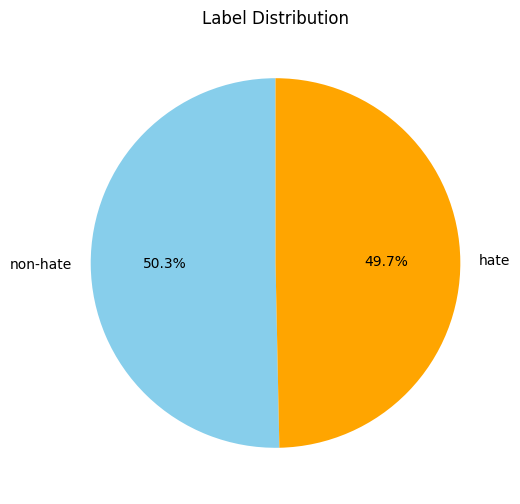

In [18]:
label_counts = mega_df['label'].value_counts().rename({0: 'non-hate', 1: 'hate'})
# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    label_counts, 
    labels=label_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['skyblue', 'orange']
)
plt.title('Label Distribution')
plt.show()

In [19]:
mega_df['word_count'] = mega_df['sentence'].progress_apply(lambda x: utils.words(x))

  0%|          | 0/1006924 [00:00<?, ?it/s]

In [20]:
max_count = mega_df['word_count'].max()
min_count = mega_df['word_count'].min()
print(f"Min Count: {min_count}\nMax Count: {max_count}")

Min Count: 0
Max Count: 280


In [21]:
# corpus where sentences exist
mega_df_v1 = mega_df[mega_df['word_count'] > 0]
max_count_v1 = mega_df_v1['word_count'].max()
min_count_v1 = mega_df_v1['word_count'].min()
print(f"Min Count: {min_count_v1}\nMax Count: {max_count_v1}")

Min Count: 1
Max Count: 280


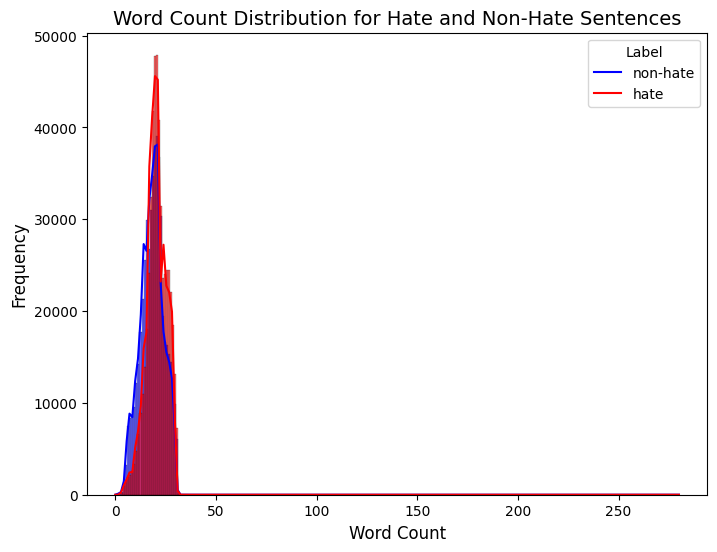

In [22]:
# Create the histogram plot
plt.figure(figsize=(8, 6))
sns.histplot(
    data=mega_df, 
    x='word_count', 
    hue='annotation', 
    kde=True,  # Adds a KDE curve for smoother visualization
    bins=280,   # Number of bins for the histogram
    palette={'hate': 'red', 'non-hate': 'blue'},  # Custom colors
    alpha=0.6  # Transparency for the bars
)

# Add labels and title
plt.title('Word Count Distribution for Hate and Non-Hate Sentences', fontsize=14)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Label', labels=['non-hate', 'hate'])
plt.show()


In [23]:
hate_group = mega_df[mega_df['label'] == 1]['word_count'].tolist()
nonhate_group = mega_df[mega_df['label'] == 0]['word_count'].tolist()

# Perform a two-sample t-test
t_stat, p_value = stats.ttest_ind(hate_group, nonhate_group)

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 186.0444694315183
P-value: 0.0


In [24]:
hate_mean = mega_df[mega_df['label'] == 1]['word_count'].mean()
nonhate_mean = mega_df[mega_df['label'] == 0]['word_count'].mean()
print(f"Hate Mean: {hate_mean:.4f}, Non-Hate Mean: {nonhate_mean:.4f}")

Hate Mean: 20.2282, Non-Hate Mean: 18.2288


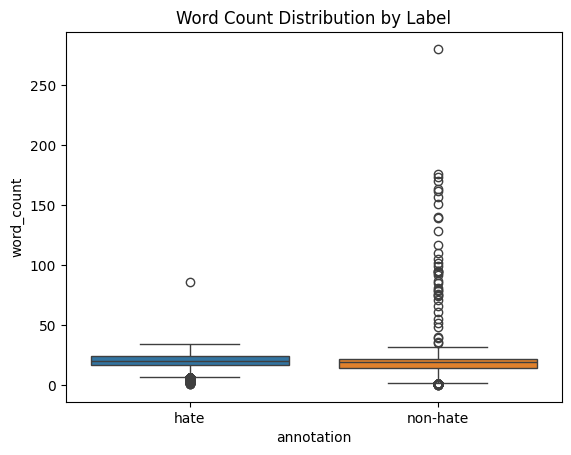

In [25]:
sns.boxplot(data=mega_df, x='annotation', y='word_count', hue='annotation')
plt.title('Word Count Distribution by Label')
plt.show()

In [ ]:
def get_hate_only_words(df, text_col='text', label_col='label', map={"non-hate": 0, "hate": 1}):
    """
    Returns a dictionary of words that exist in hate texts but not in non-hate texts.
    The dictionary also contains the word counts of those words.
    
    Args:
        dataframe (pd.DataFrame): The input DataFrame containing text and labels.
        text_col (str): The name of the column containing text data.
        label_col (str): The name of the column containing labels ('hate' or 'non-hate').
    
    Returns:
        hate_only_words (Dict[str, int]): A dictionary with words as keys and their counts in hate texts as values.
    """
    # Separate hate and non-hate texts
    hate_texts = df[df[label_col] == map['hate']][text_col].str.cat(sep=' ')
    non_hate_texts = df[df[label_col] == map['non-hate']][text_col].str.cat(sep=' ')
    
    # Tokenize the texts using nltk.word_tokenize
    hate_words = Counter(nltk.word_tokenize(hate_texts))
    non_hate_words = set(nltk.word_tokenize(non_hate_texts))
    
    # Extract words exclusive to hate texts
    hate_only_words = Counter({word: count for word, count in hate_words.items() if word not in non_hate_words})
    hate_only_words = Counter(dict(hate_only_words.most_common()))
    # Return a sorted Counter object
    return hate_only_words

def get_vocab_size(df, text_col='sentence', label_col='label', label=0, return_vocab=False):
    """Concatenate all of the documents in the text column that have a given label, tokenize the corpus, 
    get the unique words, then calculate |V|.

    Args:
        df (pd.DataFrame): Contains the sentences and labels
        text_col (str): The column with sentences
        label_col (str): Column with labels
        return_vocab (bool): Whether to return the vocabulary V

    Returns:
        vocab_size (int): Number of words in V
        vocab (List[str]): The unique words
    """
    texts = df[df[label_col] == label][text_col].str.cat(sep=' ')
    vocab = set(nltk.word_tokenize(texts))
    vocab_size = len(vocab)
    if return_vocab:
        return (vocab_size, vocab)
    else:
        return vocab_size

def doc_vocab_size(sentence):
    """Calculates the number of unique words in a sentence

    Args:
        sentence (str): A sentence from the corpus

    Returns:
        vocab_size (int): The number of unique words in the sentence
    """
    vocab = set(nltk.word_tokenize(sentence))
    vocab_size = len(vocab)
    return vocab_size

In [26]:
hate_only_words = utils.get_hate_only_words(mega_df, text_col='sentence')

In [27]:
print(f"There are {len(hate_only_words):,} words in the hate corpus that are not in the non-hate corpus")
hate_only_words.most_common(10)

There are 215,303 words in the hate corpus that are not in the non-hate corpus


[('buildthatwall', 1551),
 ('mohammeds', 996),
 ('hadiths', 990),
 ('nodaca', 578),
 ('islamolunatics', 528),
 ('enddaca', 498),
 ('islamthe', 430),
 ('endchainmigration', 329),
 ('apostates', 308),
 ('deportthemall', 308)]

In [30]:
num_words = {}
for threshold in tqdm(range(2, 26)):
    top_words = Counter({key: count for key, count in hate_only_words.items() if count >= threshold})
    n = len(top_words)
    num_words[threshold] = n

  0%|          | 0/24 [00:00<?, ?it/s]

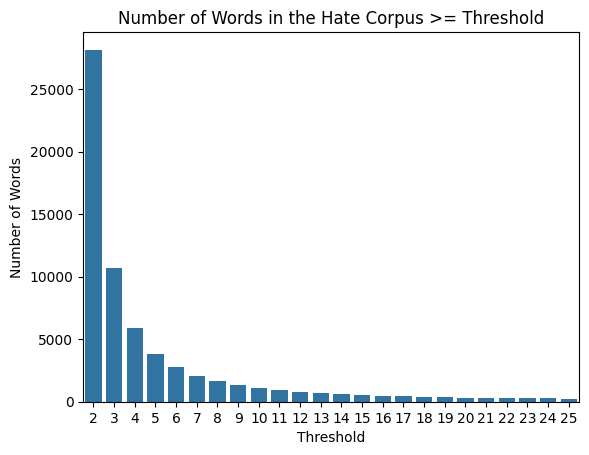

In [31]:
# How many times do we need to see a word to learn its meaning?
sns.barplot(x=list(num_words.keys()), y=list(num_words.values()))
plt.xlabel("Threshold")
plt.ylabel("Number of Words")
plt.title("Number of Words in the Hate Corpus >= Threshold")
plt.show()

In [32]:
total = 0
hate_only_frequencies = {}
for c in hate_only_words.values():
    total += c

for w, c in hate_only_words.items():
    hate_only_frequencies[w] = c / total

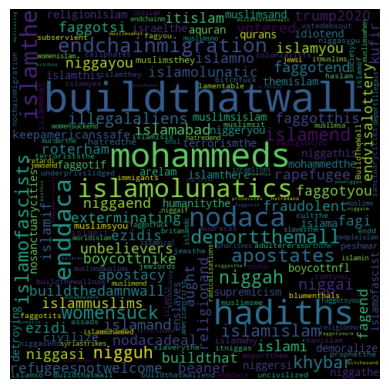

In [33]:
word_cloud = wordcloud.WordCloud(width=480, height=480, margin=0).generate_from_frequencies(hate_only_frequencies)

# Display the generated image:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [34]:
hate_vocab_size = utils.get_vocab_size(mega_df, label=1)
nonhate_vocab_size = utils.get_vocab_size(mega_df, label=0)

print(f"|V_hate| = {hate_vocab_size:,}")
print(f"|V_nonhate| = {nonhate_vocab_size:,}")

|V_hate| = 308,673
|V_nonhate| = 477,706


In [35]:
mega_df['num_unique_words'] = mega_df['sentence'].progress_apply(lambda x: utils.doc_vocab_size(x))

  0%|          | 0/1006924 [00:00<?, ?it/s]

In [36]:
hate_unique_count = mega_df[mega_df['label'] == 1]['num_unique_words'].tolist()
nonhate_unique_count = mega_df[mega_df['label'] == 0]['num_unique_words'].tolist()

# Perform a two-sample t-test
t_stat, p_value = stats.ttest_ind(hate_unique_count, nonhate_unique_count)

print("T-statistic:", t_stat)
print("P-value:", p_value)

hate_unique_mean = mega_df[mega_df['label'] == 1]['num_unique_words'].mean()
nonhate_unique_mean = mega_df[mega_df['label'] == 0]['num_unique_words'].mean()
print(f"Hate Mean: {hate_unique_mean:.4f}, Non-Hate Mean: {nonhate_unique_mean:.4f}")

T-statistic: 170.4822539604377
P-value: 0.0
Hate Mean: 18.3662, Non-Hate Mean: 16.7768


In [37]:
hate_wc_mode = max(set(hate_group), key=hate_group.count)
nonhate_wc_mode = max(set(nonhate_group), key=nonhate_group.count)
hate_uwc_mode = max(set(hate_unique_count), key=hate_unique_count.count)
nonhate_uwc_mode = max(set(nonhate_unique_count), key=nonhate_unique_count.count)

print(f"Hate Word Count Mode: {hate_wc_mode}")
print(f"Non-Hate Word Count Mode: {nonhate_wc_mode}")
print(f"Hate Unique Word Count Mode: {hate_uwc_mode}")
print(f"Non-Hate Unique Word Count Mode: {nonhate_uwc_mode}")

Hate Word Count Mode: 20
Non-Hate Word Count Mode: 20
Hate Unique Word Count Mode: 18
Non-Hate Unique Word Count Mode: 18


In [38]:
mega_df_v1 = mega_df[mega_df['num_unique_words'] > 0]
umax_count = mega_df_v1['num_unique_words'].max()
umin_count = mega_df_v1['num_unique_words'].min()
print(f"Min Count: {umin_count}\nMax Count: {umax_count}")

Min Count: 1
Max Count: 31


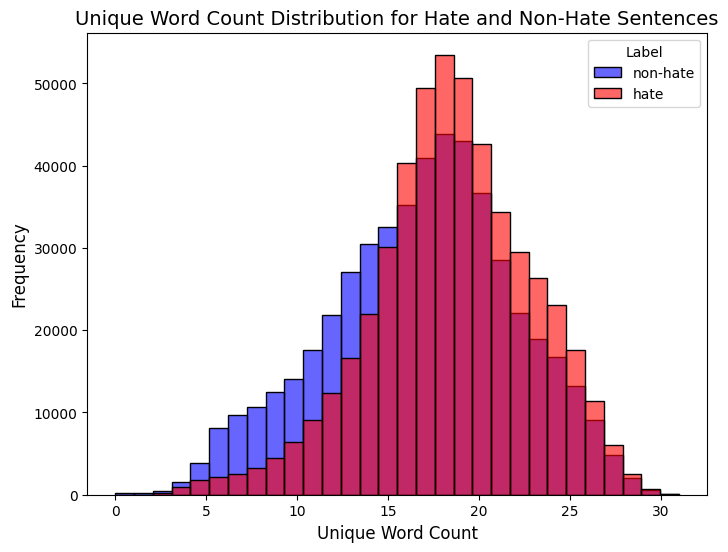

In [39]:
# Create the histogram plot
plt.figure(figsize=(8, 6))
sns.histplot(
    data=mega_df, 
    x='num_unique_words', 
    hue='annotation', 
    kde=False,  # Adds a KDE curve for smoother visualization
    bins=30,   # Number of bins for the histogram
    palette={'hate': 'red', 'non-hate': 'blue'},  # Custom colors
    alpha=0.6  # Transparency for the bars
)

# Add labels and title
plt.title('Unique Word Count Distribution for Hate and Non-Hate Sentences', fontsize=14)
plt.xlabel('Unique Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Label', labels=['non-hate', 'hate'])
plt.show()


In [41]:
nlp = spacy.load("en_core_web_sm")

In [42]:
mega_df.columns

Index(['sentence', 'label', 'annotation', 'word_count', 'num_unique_words'], dtype='object')

In [81]:
mega_df = utils.create_pos_columns(mega_df, nlp=nlp, text_col="sentence")

In [78]:
pos_df_ = pd.json_normalize(mega_df['pos_counts'])
mega_df_r = mega_df.reset_index()

In [80]:
pos_mega_df = pd.concat([mega_df_r, pos_df_], axis=1).drop(columns=['pos_counts'])
pos_mega_df.head()

,index,sentence,label,annotation,word_count,num_unique_words,,ADJ,ADP,ADV,...,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,EOL,SPACE
0,0,Howd they do that Stupidly deceive everyone th...,1,hate,23,21,0,2,3,1,...,1,5,0,0,1,0,6,0,0,0
1,1,everyone is a nigger sympathizer or faggot any...,1,hate,11,9,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
2,2,asi hate how the niggers fuck over niggers lol...,1,hate,11,10,0,0,1,1,...,0,0,3,0,1,0,2,0,0,0
3,3,regress relapse dieboo hoe i love your nasty l...,1,hate,14,14,0,1,0,0,...,0,4,1,0,0,0,2,0,0,0
4,4,of course i want to be your bitch so ill whip ...,1,hate,20,20,0,2,0,3,...,2,2,3,0,1,0,2,0,0,0


In [92]:
# 21 possible parts of speech
# 13 groups
pos = list(spacy.parts_of_speech.IDS.keys())
d = {
    'pos': [],
    'p_value': [],
    't_stat': [],
     'hate_mean': [],
     'nonhate_mean': [],
     'hate_mode': [],
     'nonhate_mode': [],
    'ci_low': [],
    'ci_high': [],
    'ci_range': [],
    'mode_diff': []}

for p in pos:
    posc1 = pos_mega_df[pos_mega_df['label'] == 0][p].tolist()
    posc2 = pos_mega_df[pos_mega_df['label'] == 1][p].tolist()

    mean1 = pos_mega_df[pos_mega_df['label'] == 0][p].mean()
    mean2 = pos_mega_df[pos_mega_df['label'] == 1][p].mean()

    mode1 = max(set(posc1), key=posc1.count)
    mode2 = max(set(posc2), key=posc2.count)

    mode_diff = abs(mode1 - mode2)

    t_stat, p_value = stats.ttest_ind(posc1, posc2)
    ci = stats.ttest_ind(posc1, posc2).confidence_interval()
    ci_range = float(ci[1] - ci[0])

    if p_value < .05:
        d['pos'].append(p)
        d['p_value'].append(p_value)
        d['t_stat'].append(t_stat)
        d['hate_mean'].append(mean2)
        d['nonhate_mean'].append(mean1)
        d['hate_mode'].append(mode2)
        d['nonhate_mode'].append(mode1)
        d['ci_low'].append(float(ci[0]))
        d['ci_high'].append(float(ci[1]))
        d['mode_diff'].append(mode_diff)
        d['ci_range'].append(ci_range)

posc_stats_df = pd.DataFrame(d)
posc_stats_df.sort_values(by=['mode_diff', 'ci_range'], ascending=[False, True])

,pos,p_value,t_stat,hate_mean,nonhate_mean,hate_mode,nonhate_mode,ci_low,ci_high,ci_range,mode_diff
9,PRON,0.000000e+00,-120.347693,2.308283,1.894690,2,0,-0.420329,-0.406857,0.013471,2
2,AUX,0.000000e+00,-211.131706,1.635785,1.148505,1,0,-0.491804,-0.482757,0.009047,1
4,DET,0.000000e+00,-137.063544,1.894242,1.543290,2,1,-0.355971,-0.345934,0.010037,1
1,ADP,1.039677e-21,-9.573101,1.982592,1.956000,2,1,-0.032036,-0.021148,0.010889,1
11,PUNCT,1.485886e-187,29.215302,0.002311,0.006172,0,0,0.003602,0.004120,0.000518,0
16,SPACE,2.495176e-191,29.511229,0.007668,0.013723,0,0,0.005653,0.006457,0.000804,0
15,X,5.137121e-104,21.660278,0.009294,0.014262,0,0,0.004519,0.005418,0.000899,0
5,INTJ,9.728227e-256,34.169212,0.061751,0.081888,0,0,0.018983,0.021293,0.002310,0
12,SCONJ,0.000000e+00,-119.132485,0.535436,0.374531,0,0,-0.163552,-0.158258,0.005294,0
7,NUM,0.000000e+00,157.878319,0.153150,0.368326,0,0,0.212505,0.217847,0.005343,0


In [94]:
mega_hate_pron = utils.pos_word_counter(pos_mega_df[pos_mega_df['label'] == 1], 
                                   text_column='sentence', pos_name='PRON', nlp=nlp, group=None)
mega_hate_pron.most_common(10)

  0%|          | 0/500125 [00:00<?, ?it/s]

[('they', 1),
 ('that', 1),
 ('everyone', 1),
 ('them', 1),
 ('i', 1),
 ('your', 1),
 ('you', 1),
 ('what', 1),
 ('all', 1),
 ('it', 1)]

In [98]:
print(f"There are {len(mega_hate_pron):,} hate pronouns in MegaSpeech")
mega_hate_pron.most_common()[-10:-1]

There are 4,741 hate pronouns in MegaSpeech


[('thinkthe', 1),
 ('untitledyou', 1),
 ('timesthere', 1),
 ('economythey', 1),
 ('rednationrisingyou', 1),
 ('citiesdevs', 1),
 ('trudeathis', 1),
 ('yourthis', 1),
 ('h3this', 1)]

In [95]:
total = 0
mega_hate_pron_frequencies = {}
for c in mega_hate_pron.values():
    total += c

for w, c in mega_hate_pron.items():
    mega_hate_pron_frequencies[w] = c / total

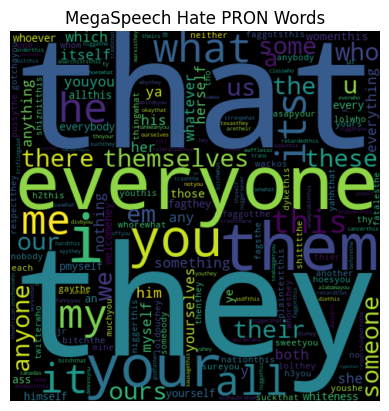

In [96]:
word_cloud = wordcloud.WordCloud(width=480, height=480, margin=0).generate_from_frequencies(mega_hate_pron_frequencies)

# Display the generated image:
plt.title('MegaSpeech Hate PRON Words')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()